In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_json(file_path):
    data = []
    with open(file_path, 'r') as f:
        line = f.readline()
        while line:
            data.append(json.loads(line))
            line = f.readline()
    return pd.DataFrame(data)


def calculate_overall_statistics(df):
    total_time = df['total_time']
    percentiles = np.percentile(total_time, [50, 75, 85, 90, 95, 99])
    
    overall_stats = {
        'avg': total_time.mean(),
        'max': total_time.max(),
        'p50': percentiles[0],
        'p75': percentiles[1],
        'p85': percentiles[2],
        'p90': percentiles[3],
        'p95': percentiles[4],
        'p99': percentiles[5]
    }
    
    return pd.DataFrame([overall_stats])


def calculate_statistics(df):
    bin_size = 5000000
    df = df.copy()
    df.loc[:, 'gas_used_range'] = pd.cut(df['gas_used'], bins=np.arange(0, df['gas_used'].max() + bin_size, bin_size))
    
    grouped = df.groupby('gas_used_range', observed=False)['total_time']

    def under_1_sec_percentage(x):
        return (x < 1).sum() / x.count() * 100

    def under_2_sec_percentage(x):
        return (x < 2).sum() / x.count() * 100

    distribution = grouped.agg(
        avg='mean',
        max='max',
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p85=lambda x: np.percentile(x, 85),
        p90=lambda x: np.percentile(x, 90),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99),
        count='count',
        under_1s_rate=under_1_sec_percentage,
        under_2s_rate=under_2_sec_percentage,
    ).reset_index()

    overall_under_1_sec_percentage = under_1_sec_percentage(df['total_time'])
    overall_under_2_sec_percentage = under_2_sec_percentage(df['total_time'])

    overall_stats = calculate_overall_statistics(df).iloc[0]
    max_gas_used = int((df['gas_used'].max() + bin_size) / bin_size) * bin_size 
    overall_stats['gas_used_range'] = f"(0, {max_gas_used}]"
    overall_stats['count'] = df['total_time'].count()
    overall_stats['under_1s_rate'] = overall_under_1_sec_percentage
    overall_stats['under_2s_rate'] = overall_under_2_sec_percentage

    distribution = pd.concat([distribution, pd.DataFrame([overall_stats])], ignore_index=True)

    return distribution, overall_under_1_sec_percentage, grouped


def plot_histogram(grouped, gas_range):
    total_times = grouped.get_group(gas_range)

    plt.figure(figsize=(10, 6))
    plt.hist(total_times, bins=50, edgecolor='black')
    plt.title(f'Histogram of total_time for gas_used_range {gas_range}')
    plt.xlabel('total_time')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

In [2]:
df_archive = load_json('base_archive_high_cache.json')
df_full = load_json('base_full_high_cache.json')
df_reth = load_json('base_reth_maxperf.json')

common_blocks = set(df_archive['block_number']).intersection(df_full['block_number']).intersection(df_reth['block_number'])

df_archive = df_archive[df_archive['block_number'].isin(common_blocks)]
df_full = df_full[df_full['block_number'].isin(common_blocks)]
df_reth = df_reth[df_reth['block_number'].isin(common_blocks)]

distribution_archive, under_1_sec_archive, grouped_archive = calculate_statistics(df_archive)
distribution_full, under_1_sec_full, grouped_full = calculate_statistics(df_full)
distribution_reth, under_1_sec_reth, grouped_reth = calculate_statistics(df_reth)

In [3]:
print(f"op-geth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_archive:.4f}% is under 1s")
distribution_archive

op-geth archive node | base-mainnet 5492540 ~ 9816497 | 98.8569% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.046237,8.828,0.021,0.029,0.035,0.041,0.05500,0.60000,4031198,99.168287,99.537358
1,"(5000000, 10000000]",0.420911,10.715,0.176,0.671,0.841,0.891,0.99000,2.37850,85676,95.262384,98.863159
2,"(10000000, 15000000]",0.314018,9.506,0.150,0.224,0.700,0.823,0.93800,1.96141,32238,95.986103,99.016688
3,"(15000000, 20000000]",0.392005,10.289,0.213,0.361,0.417,0.695,1.37830,2.64866,38035,91.097673,98.012357
4,"(20000000, 25000000]",0.554870,9.974,0.474,0.554,0.608,0.736,1.51105,3.83156,48460,92.311184,97.269913
5,"(25000000, 30000000]",0.584489,9.895,0.520,0.579,0.625,0.676,0.84200,4.14550,88351,96.112098,97.765730
6,"(0, 30000000]",0.075398,10.715,0.022,0.032,0.043,0.063,0.34000,1.17700,4323958,98.856881,99.445092


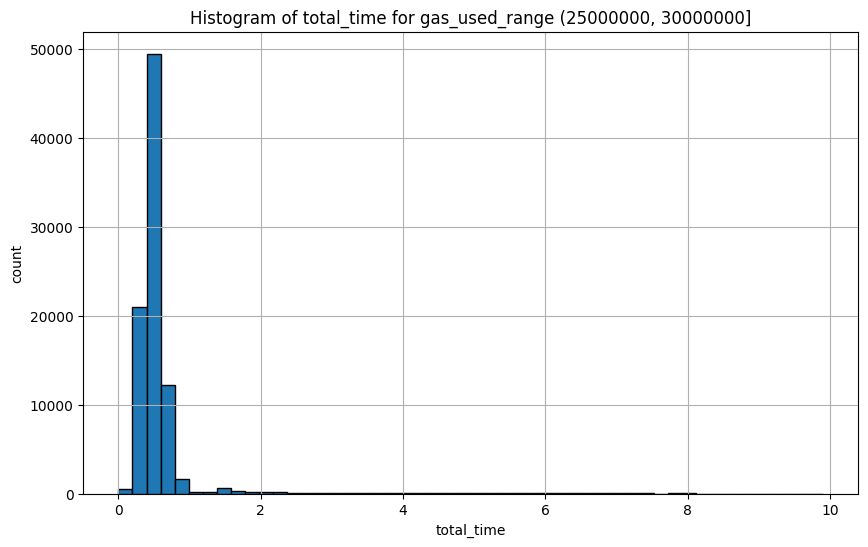

In [4]:
plot_histogram(grouped_archive, distribution_archive.loc[5, 'gas_used_range'])

In [5]:
print(f"op-geth full node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_full:.4f}% is under 1s")
distribution_full

op-geth full node | base-mainnet 5492540 ~ 9816497 | 99.8995% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.021772,4.760,0.018,0.026,0.031,0.0360,0.043,0.06600,4031198,99.999231,99.999777
1,"(5000000, 10000000]",0.263921,5.854,0.124,0.428,0.555,0.5810,0.624,0.87825,85676,99.439750,99.883281
2,"(10000000, 15000000]",0.212934,5.765,0.137,0.180,0.439,0.5500,0.603,0.87189,32238,99.503691,99.950369
3,"(15000000, 20000000]",0.268152,6.338,0.196,0.243,0.274,0.4046,0.856,1.35900,38035,97.326147,99.936900
4,"(20000000, 25000000]",0.348978,6.234,0.310,0.358,0.384,0.4430,0.875,1.30800,48460,96.817994,99.886504
5,"(25000000, 30000000]",0.356015,5.154,0.337,0.372,0.394,0.4170,0.572,1.06800,88351,98.736856,99.897002
6,"(0, 30000000]",0.040659,6.338,0.019,0.028,0.037,0.0470,0.177,0.43100,4323958,99.899490,99.993178


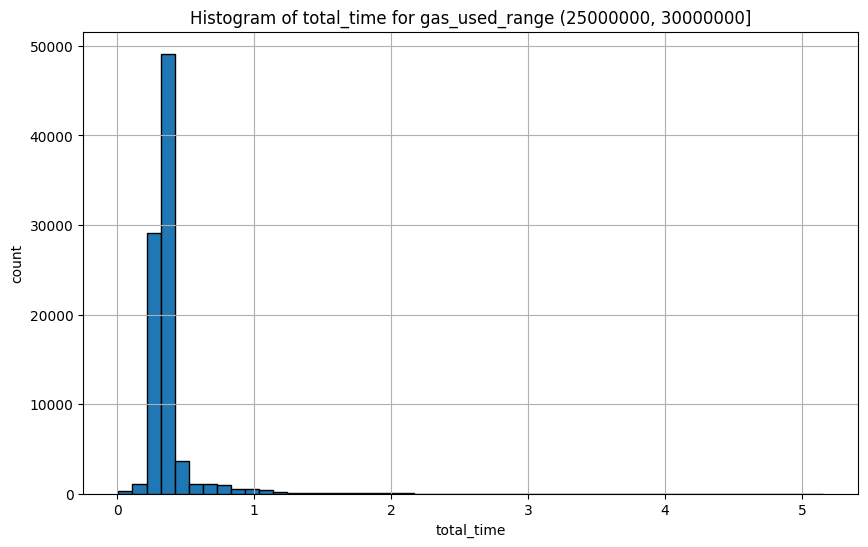

In [6]:
plot_histogram(grouped_full, distribution_full.loc[5, 'gas_used_range'])

In [7]:
print(f"op-reth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_reth:.4f}% is under 1s")
distribution_reth

op-reth archive node | base-mainnet 5492540 ~ 9816497 | 99.6106% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.043580,1.649,0.040,0.054,0.063,0.0700,0.081,0.10600,4031198,99.997941,100.000000
1,"(5000000, 10000000]",0.398478,6.887,0.170,0.643,0.848,0.9330,1.038,1.35900,85676,93.447407,99.756058
2,"(10000000, 15000000]",0.262277,6.519,0.124,0.213,0.629,0.7440,0.956,1.23063,32238,96.380048,99.934859
3,"(15000000, 20000000]",0.332809,5.035,0.154,0.432,0.525,0.6460,1.199,1.66266,38035,92.659393,99.576706
4,"(20000000, 25000000]",0.550650,8.358,0.549,0.749,0.832,0.9001,1.183,1.72441,48460,92.688816,99.405695
5,"(25000000, 30000000]",0.579315,7.079,0.598,0.747,0.812,0.8670,0.970,1.46500,88351,95.881201,99.797399
6,"(0, 30000000]",0.071416,8.358,0.042,0.059,0.072,0.0850,0.146,0.80600,4323958,99.610588,99.980157


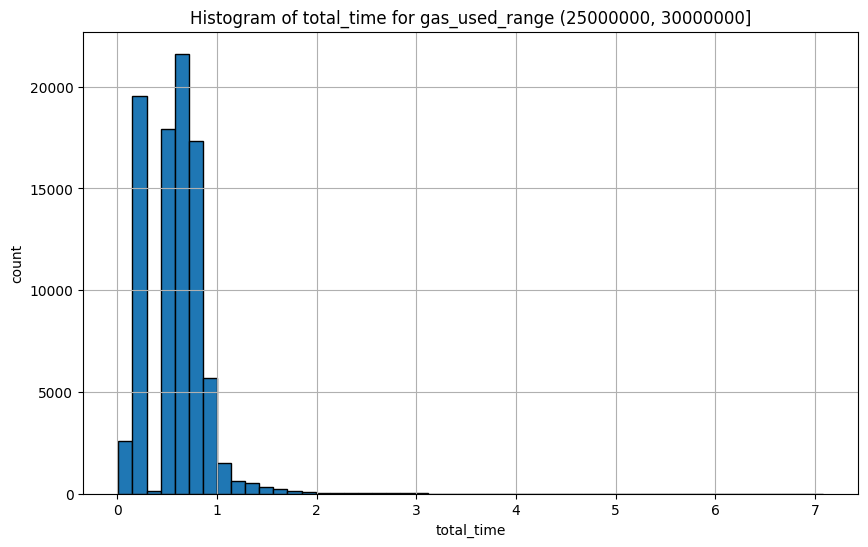

In [8]:
plot_histogram(grouped_reth, distribution_reth.loc[5, 'gas_used_range'])

In [9]:
df_snapshot_archive = load_json('base_snapshot_archive_high_cache.json')
df_snapshot_full = load_json('base_snapshot_full_high_cache.json')

distribution_snapshot_archive, under_1_sec_snapshot_archive, grouped_snapshot_archive = calculate_statistics(df_snapshot_archive)
distribution_snapshot_full, under_1_sec_snapshot_full, grouped_snapshot_full = calculate_statistics(df_snapshot_full)

In [10]:
print(f"op-geth archive node | base-mainnet {min(df_snapshot_archive['block_number'])} ~ {max(df_snapshot_archive['block_number'])} | {under_1_sec_snapshot_archive:.4f}% is under 1s")
distribution_snapshot_archive

op-geth archive node | base-mainnet 13686867 ~ 15074141 | 98.9991% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.087666,1.838,0.085,0.094,0.10000,0.106,0.13200,0.18200,77912,99.848547,100.000000
1,"(5000000, 10000000]",0.149091,3.624,0.138,0.159,0.17200,0.185,0.21800,0.30000,793956,99.630584,99.964482
2,"(10000000, 15000000]",0.220875,4.264,0.194,0.221,0.24300,0.266,0.31200,0.94900,351597,99.029002,99.707335
3,"(15000000, 20000000]",0.342358,5.180,0.261,0.305,0.35200,0.399,0.56800,2.27842,93530,96.114616,98.440073
4,"(20000000, 25000000]",0.437949,5.240,0.334,0.400,0.45705,0.520,1.13135,2.46900,38494,94.742038,97.552865
5,"(25000000, 30000000]",0.515247,5.299,0.404,0.472,0.54200,0.622,1.14975,3.19975,31786,94.456679,96.658906
6,"(0, 30000000]",0.193269,5.299,0.157,0.203,0.24200,0.277,0.35000,1.00100,1387275,98.999117,99.655872


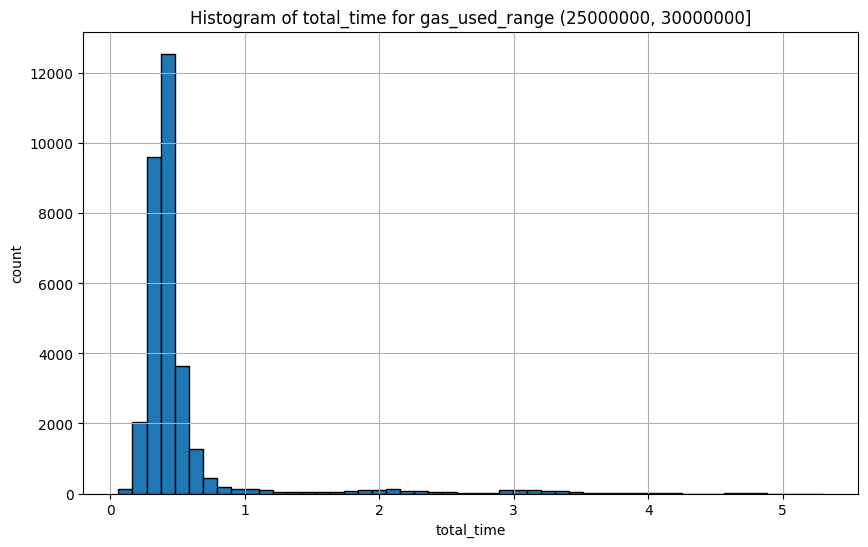

In [11]:
plot_histogram(grouped_snapshot_archive, distribution_snapshot_archive.loc[5, 'gas_used_range'])

In [12]:
print(f"op-geth full node | base-mainnet {min(df_snapshot_full['block_number'])} ~ {max(df_snapshot_full['block_number'])} | {under_1_sec_snapshot_full:.4f}% is under 1s")
distribution_snapshot_full

op-geth full node | base-mainnet 14567037 ~ 15074141 | 99.6606% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.086393,0.816,0.083,0.090,0.097,0.111,0.14300,0.17200,36610,100.000000,100.000000
1,"(5000000, 10000000]",0.137372,2.670,0.129,0.149,0.161,0.177,0.21600,0.27400,279850,99.973557,99.999285
2,"(10000000, 15000000]",0.200002,4.984,0.182,0.207,0.229,0.259,0.30400,0.49000,125950,99.667328,99.984121
3,"(15000000, 20000000]",0.278606,5.207,0.239,0.277,0.317,0.358,0.44700,1.31835,36674,98.301249,99.920925
4,"(20000000, 25000000]",0.345422,3.160,0.305,0.347,0.388,0.446,0.56675,1.34405,15966,97.544783,99.887260
5,"(25000000, 30000000]",0.382984,2.773,0.354,0.404,0.455,0.508,0.60200,1.12792,12055,98.233098,99.950228
6,"(0, 30000000]",0.171850,5.207,0.148,0.193,0.230,0.263,0.32300,0.54000,507105,99.660623,99.985210


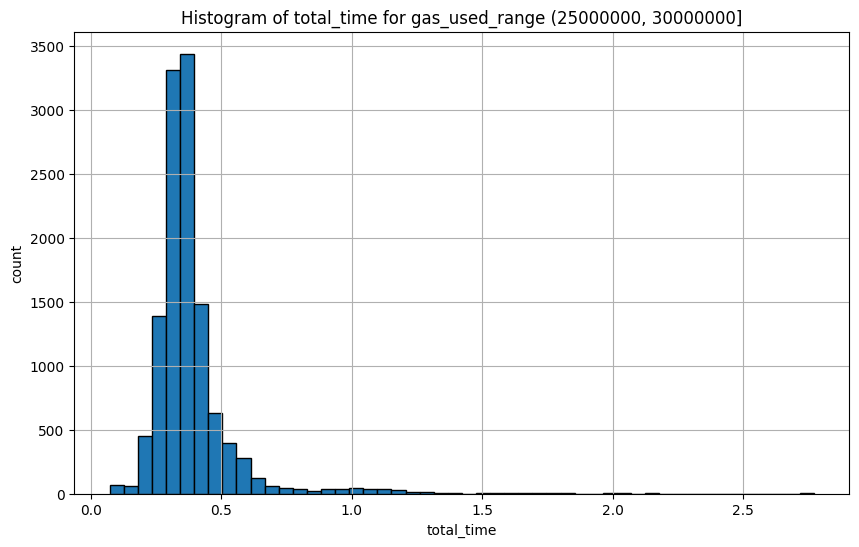

In [13]:
plot_histogram(grouped_snapshot_full, distribution_snapshot_full.loc[5, 'gas_used_range'])